In [2]:
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

In [38]:
data = pd.read_excel('eda_project_data.xlsx')

In [39]:
data.head(5)

,region,category,requested_amount,total_amount,status,grant_amount,duration,project_number,win_project_number,win_proportion,requested_total_proportion,grant_requested_proportion,grant_total_propotion
0,Республика Саха (Якутия),"охрана здоровья граждан, пропаганда здорового ...",499810.00,516172.50,победитель конкурса,499810.00,455.0,0,0,0.0,0.968300,1.0,0.968300
1,Москва,"социальное обслуживание, социальная поддержка ...",12546289.26,20431838.57,победитель конкурса,12546289.26,455.0,0,0,0.0,0.614056,1.0,0.614056
2,Волгоградская область,"социальное обслуживание, социальная поддержка ...",2108676.00,5570400.00,победитель конкурса,2108676.00,455.0,0,0,0.0,0.378550,1.0,0.378550
3,Москва,развитие институтов гражданского общества,5233932.00,7715932.00,проект не получил поддержки,0.00,364.0,0,0,0.0,0.678328,0.0,0.000000
4,Москва,развитие институтов гражданского общества,2960275.00,5687025.00,победитель конкурса,2960275.00,395.0,0,0,0.0,0.520531,1.0,0.520531


In [40]:
data.drop(['grant_amount', 'grant_requested_proportion', 'grant_total_propotion'], axis=1, inplace=True)

In [41]:
data['status'] = data['status'].apply(lambda x: 1 if x == 'победитель конкурса' else 0)

In [42]:
data

,region,category,requested_amount,total_amount,status,duration,project_number,win_project_number,win_proportion,requested_total_proportion
0,Республика Саха (Якутия),"охрана здоровья граждан, пропаганда здорового ...",499810.00,516172.50,1,455.0,0,0,0.000000,0.968300
1,Москва,"социальное обслуживание, социальная поддержка ...",12546289.26,20431838.57,1,455.0,0,0,0.000000,0.614056
2,Волгоградская область,"социальное обслуживание, социальная поддержка ...",2108676.00,5570400.00,1,455.0,0,0,0.000000,0.378550
3,Москва,развитие институтов гражданского общества,5233932.00,7715932.00,0,364.0,0,0,0.000000,0.678328
4,Москва,развитие институтов гражданского общества,2960275.00,5687025.00,1,395.0,0,0,0.000000,0.520531
...,...,...,...,...,...,...,...,...,...,...
101641,Иркутская область,"Поддержка семьи, материнства, отцовства и дет...",488663.00,588743.00,0,180.0,0,0,0.000000,0.830011
101642,Москва,"Социальное обслуживание, социальная поддержка ...",740571.90,1047124.90,1,120.0,0,0,0.000000,0.707243
101643,Москва,Укрепление межнационального и межрелигиозного ...,2994680.00,4473680.00,0,305.0,7,1,0.142857,0.669400
101644,Самарская область,"Защита прав и свобод человека и гражданина, в ...",464310.00,725326.00,0,180.0,1,0,0.000000,0.640140


In [43]:
df1 = data[data['status'] == 0].head(22000)
df2 = data[data['status'] ==1]
balanced_data = pd.concat([df1, df2])

In [9]:
data = balanced_data

In [10]:
# построим ROC-кривую
def plot_roc_curve(y_test, y_pred):
    fper, tper, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fper, tper)
    plt.plot(fper, tper, color='green', label=f'ROC-кривая (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC AUC (area = {roc_auc:.3f})')
    plt.legend(loc="lower right")
    plt.show()

In [11]:
### Quality func
def quality_report(prediction, actual):
    print((f" Accuracy: {accuracy_score(prediction, actual):.3f}\n \
Precision: {precision_score(prediction, actual):.3f}\n \
Recall: {recall_score(prediction, actual):.3f}\n \
f1_score: {f1_score(prediction, actual):.3f}"))

In [44]:
X = data.drop('status', axis=1)
Y = data['status']
#Train test split
train_X, X_test, train_Y, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
train_X.shape, X_test.shape, train_Y.shape, y_test.shape


# validation-train split
X_train, X_validation, y_train, y_validation = train_test_split(train_X, train_Y, train_size=0.75, random_state=42)


In [45]:
# validation-train split
X_train, X_validation, y_train, y_validation = train_test_split(train_X, train_Y, train_size=0.75, random_state=42)


In [52]:
# {'params': {'depth': 5, 'iterations': 400, 'learning_rate': 0.03}
est = CatBoostClassifier(iterations=500, 
                         cat_features=['region', 'category'],
                         logging_level='Silent', 
#                          loss_function='', 
                         eval_metric='Precision',
                         learning_rate = 0.05,
                         max_depth = 5, 
                        roc_file = "roc-file")
est.fit(
    X_train, y_train,
    cat_features=['region', 'category'],
    eval_set=(X_validation, y_validation),
    plot=True
)

quality_report(est.predict(X_test), y_test)
print('ROC-AUC', round(roc_auc_score(y_test, est.predict_proba(X_test)[:,1]),3))

TypeError: __init__() got an unexpected keyword argument 'roc_file'

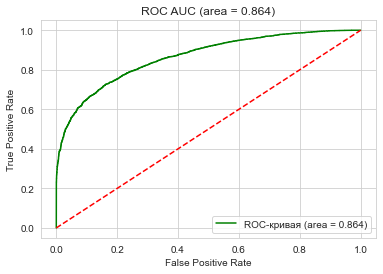

In [31]:
plot_roc_curve(y_test, est.predict_proba(X_test)[:,1])

In [ ]:
# построим ROC-кривую
def plot_roc_curve(y_test, y_pred):
    fper, tper, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fper, tper)
    plt.plot(fper, tper, color='green', label=f'ROC-кривая (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC AUC (area = {roc_auc:.3f})')
    plt.legend(loc="lower right")
    plt.show()

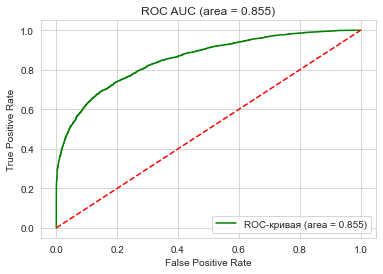

In [40]:
plot_roc_curve(y_test, est.predict_proba(X_test)[:,1])

In [32]:
data = pd.read_excel('one_hot_data.xlsx')

In [33]:
df1 = data[data['status'] == 0].head(22000)
df2 = data[data['status'] ==1]
data = pd.concat([df1, df2])

In [34]:
X = data.drop('status', axis=1)
Y = data['status']
#Train test split
train_X, X_test, train_Y, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
train_X.shape, X_test.shape, train_Y.shape, y_test.shape


# validation-train split
X_train, X_validation, y_train, y_validation = train_test_split(train_X, train_Y, train_size=0.75, random_state=42)


In [35]:
from catboost import CatBoostClassifier 

est = CatBoostClassifier(iterations=200, logging_level='Silent', max_depth = 3)
est.fit(X_train, y_train)

pred = est.predict(X_train)
est.predict_proba(X_train)[0]  
print('ROC-AUC', round(roc_auc_score(y_test, est.predict_proba(X_test)[:,1]),3))

ROC-AUC 0.861


In [36]:
quality_report(est.predict(X_test), y_test)

 Accuracy: 0.776
 Precision: 0.732
 Recall: 0.796
 f1_score: 0.763


In [53]:
params = {"iterations": 100,
          "depth": 2,
          "loss_function": "Logloss",
          "verbose": False,
          "roc_file": "roc-file"}

scores = cv(cv_dataset,
            params,
            fold_count=2)


NameError: name 'cv' is not defined